# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/DEHMANIMOHAMMED/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

Cloning into 'exam_2025'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 99 (delta 20), reused 11 (delta 11), pack-reused 74 (from 1)
Receiving objects: 100% (99/99), 2.73 MiB | 4.73 MiB/s, done.
Resolving deltas: 100% (37/37), done.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


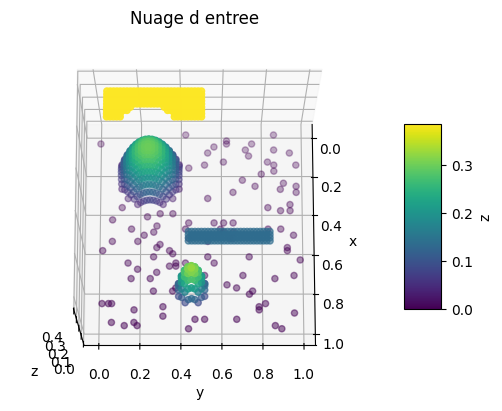

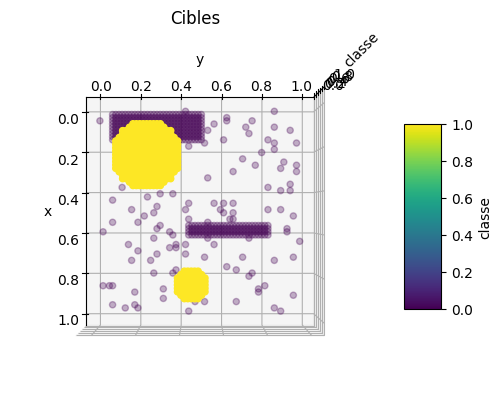

1


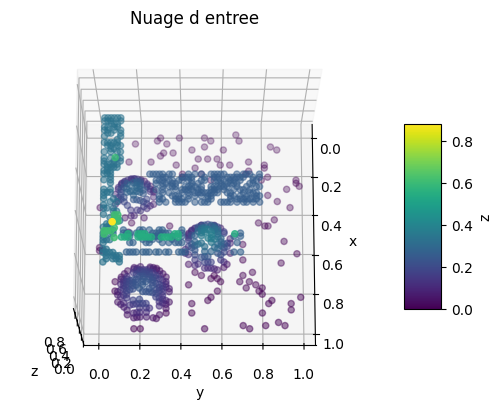

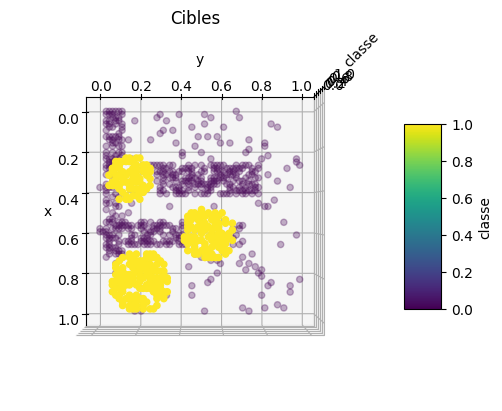

2


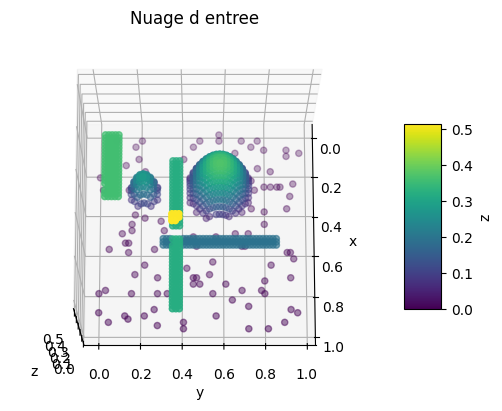

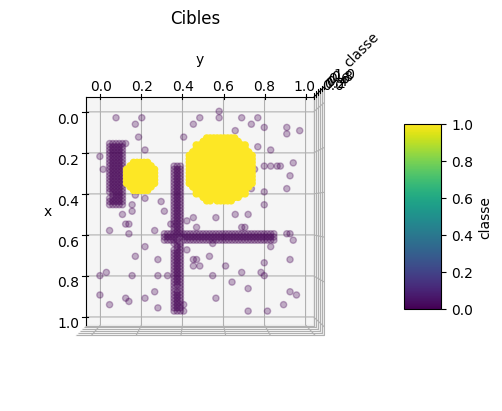

3


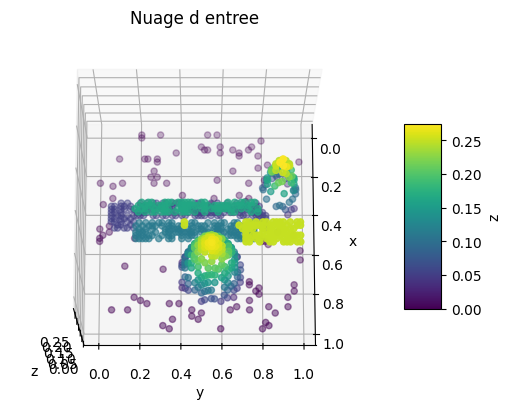

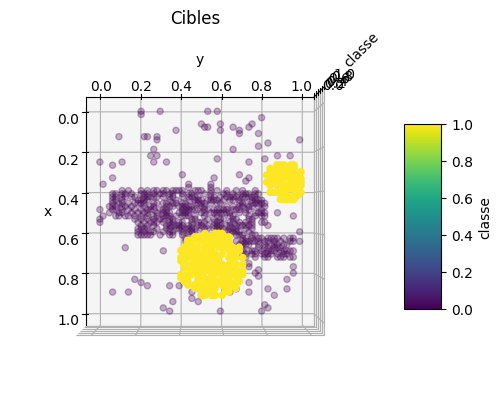

4


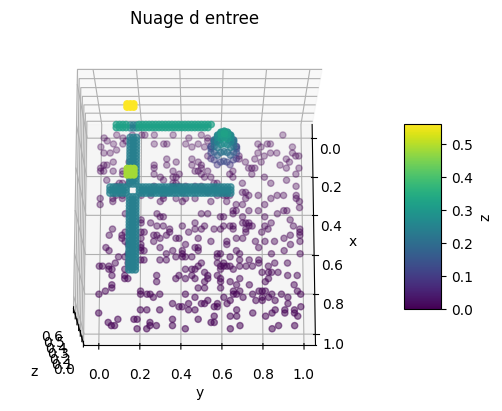

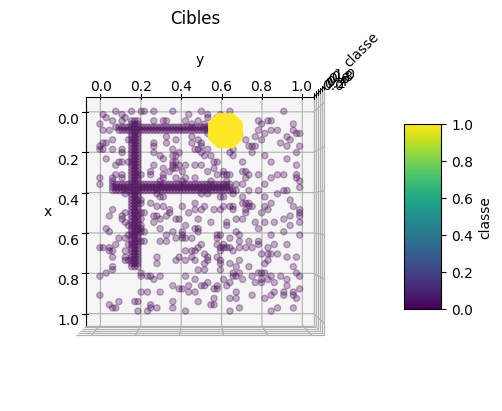

5


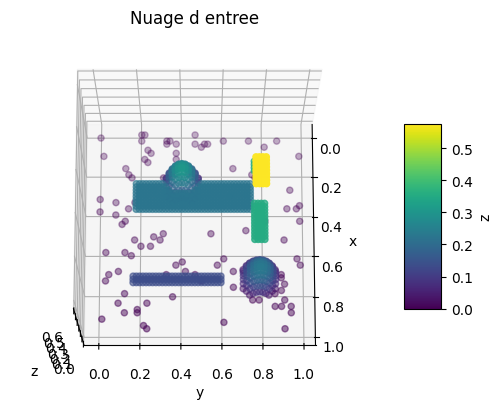

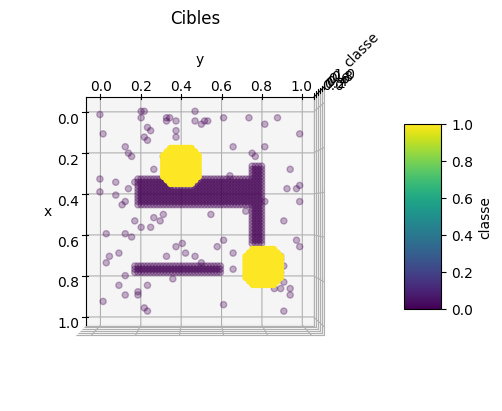

In [2]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

### Dimensions de `input_points`

Les dimensions de `input_points` sont de la forme `(batch_size, N, 3)` où :

- **batch_size** : Le nombre de nuages de points dans le lot, c'est-à-dire le nombre d'exemples traités simultanément.
- **N** : Le nombre de points dans chaque nuage de points. Ce nombre représente la quantité de points échantillonnés pour chaque objet (par exemple, les points sur les surfaces des bâtiments ou des igloos).
- **3** : Le nombre de coordonnées par point, en 3 dimensions (x, y, z), car chaque point représente une position dans l'espace 3D.

Ainsi, la dimension de `input_points` est `(batch_size, N, 3)`.

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

### Ordre des points dans un nuage de points

Les points d'un nuage de points ne sont pas rangés dans un ordre particulier. Le nuage de points est constitué de points 3D indépendants, et chaque point représente une position dans l'espace. L'ordre des points dans un nuage de points est arbitraire et n'a pas d'importance pour la tâche de segmentation.

Cependant, certains modèles comme PointNet, qui est invariante à la permutation des points, traitent ces nuages de points sans se soucier de leur ordre. D'autres architectures, comme les CNN ou ViT, peuvent avoir besoin d'un ordre particulier des points, mais ce n'est généralement pas le cas pour les modèles de segmentation de nuages de points.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

### Traitement du problème avec un FCN ou un ViT

#### 1. **Avec un FCN (Fully Convolutional Network)**

Un FCN est bien adapté aux tâches de segmentation, car il peut traiter des entrées de tailles variables tout en préservant la spatialité des données. Pour traiter un nuage de points avec un FCN, voici ce que l'on pourrait faire :

- **Prétraitement des données** : Il serait nécessaire de convertir le nuage de points 3D en une forme adaptée aux réseaux convolutifs. Une approche courante consiste à projeter les points sur des images 2D (projections orthographiques ou en profondeur) ou à utiliser une grille volumétrique (voxelization) pour représenter l'espace 3D.
- **Architecture FCN** : On pourrait utiliser un FCN pour traiter ces représentations en 2D (images projetées) ou en 3D (voxelization). Le réseau serait entraîné pour segmenter chaque point en fonction de sa classe (igloo ou autre).
- **Avantages** : Les FCN sont efficaces pour des images régulières (2D ou 3D) et peuvent utiliser les techniques classiques de convolutions et de pooling pour extraire des caractéristiques de niveau local.
- **Limites** : La voxelization peut entraîner une perte d'information, surtout pour des nuages de points peu denses.

#### 2. **Avec un ViT (Vision Transformer)**

Les Vision Transformers (ViT) ont récemment montré de très bonnes performances pour des tâches de classification et de segmentation d'images en 2D. Pour utiliser un ViT sur un nuage de points, voici comment on pourrait procéder :

- **Prétraitement des données** : Les ViT ne fonctionnent pas directement avec des données non structurées comme les nuages de points 3D. Il faudrait donc d'abord projeter les points dans un format structuré (comme une grille 2D ou un patch 3D). On pourrait aussi utiliser des techniques de **PointNet++** ou des méthodes similaires pour organiser les points avant de les passer dans un ViT.
- **Architecture ViT** : Une fois que les points sont transformés en patches (de taille fixe), le ViT peut être utilisé pour apprendre des relations globales entre ces patches à travers ses mécanismes d'attention. Cela pourrait être particulièrement utile pour capturer des relations longues distances entre les points dans un nuage 3D.
- **Avantages** : Les ViT peuvent capter des relations à longue portée dans les données grâce à l'attention, ce qui peut être un atout pour des données 3D complexes et non structurées comme celles des nuages de points.
- **Limites** : Les ViT nécessitent souvent de grandes quantités de données pour être efficaces et peuvent être plus lents à entraîner que les réseaux convolutifs classiques, en particulier sur des nuages de points peu structurés.

#### Conclusion

- **FCN** : Plus adapté si les données peuvent être projetées ou converties en représentations régulières (comme des voxels ou des images 2D). Il est plus simple et direct à implémenter si les données sont déjà organisées de cette manière.
- **ViT** : Utile pour capter des relations complexes dans les données et pourrait fonctionner bien si les points sont organisés en patches de manière appropriée, mais cela nécessiterait probablement un prétraitement avancé et plus de données d'entraînement.

Les deux approches peuvent être intéressantes, mais le choix dépendra des ressources et des caractéristiques spécifiques des données.


## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [ ]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

#### 1. **Référence à l'article de PointNet**
Dans l'article **"PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation"**, les auteurs expliquent que PointNet utilise une architecture qui est **invariante à la permutation** des points dans un nuage de points. Cela signifie que l'ordre dans lequel les points sont présentés au réseau ne doit pas affecter les prédictions du modèle. Cette propriété est rendue possible grâce à l'utilisation de fonctions d'agrégation symétriques, comme **max pooling**, qui combinent les informations de manière à ne pas dépendre de l'ordre des points dans l'entrée.

Les dimensions de `output` dans le modèle PointNet correspondent à un tenseur de la forme `(batch_size, num_points, m)`, où :
- **batch_size** : Le nombre de nuages de points traités simultanément.
- **num_points** : Le nombre de points dans chaque nuage de points (dans ce cas, 800 points).
- **m** : Le nombre de caractéristiques ou de classes prédites par point (dans ce cas, 2 pour une segmentation binaire).

L'invariance par permutation est au cœur de cette architecture, garantissant que la sortie `output` ne changera pas même si les points dans `input_points` sont permutés. Cette propriété est vérifiée expérimentalement à travers des tests, comme décrit ci-dessous.

#### 2. **Test avec `torch.randperm`**

Pour vérifier l'invariance à la permutation des points, nous allons effectuer un test où nous permutons les points dans `input_points` et comparons les sorties avant et après la permutation. Selon l'architecture de PointNet, les résultats doivent être identiques, quelle que soit l'ordre des points.

Voici le code pour effectuer ce test :


In [ ]:
import torch

# Générer un batch de nuages de points (input_points) et les cibles correspondantes
batch_size = 6
input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()

# Passer les points non permutés dans le modèle
output, _, _ = pointnet(input_points)

# Permuter les indices des points dans input_points
permutation = torch.randperm(input_points.size(1)).cuda()
input_points_permuted = input_points[:, permutation, :]

# Passer les points permutés dans le modèle
output_permuted, _, _ = pointnet(input_points_permuted)

# Vérifier si les sorties sont identiques
print("Sortie sans permutation :\n", output[0])
print("Sortie avec permutation :\n", output_permuted[0])


Sortie sans permutation :
 tensor([[ 0.6870,  0.3123],
        [ 0.4154,  0.3602],
        [ 0.6218,  0.3519],
        ...,
        [ 0.2751,  0.0214],
        [-0.6092, -1.3711],
        [ 0.4445,  0.4352]], device='cuda:0', grad_fn=<SelectBackward0>)
Sortie avec permutation :
 tensor([[ 0.0679,  0.5630],
        [-0.2308,  0.2110],
        [-0.0987,  0.3287],
        ...,
        [-0.1491,  0.0293],
        [-0.3360, -0.2327],
        [-0.2896,  0.1737]], device='cuda:0', grad_fn=<SelectBackward0>)


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

###L'architecture de PointNet pour la segmentation**

L'architecture de PointNet pour la segmentation repose sur plusieurs opérations clés :

1. **Opérations conduisant à la segmentation** :
   - **MLP partagés ("shared")** : Les mêmes transformations sont appliquées à chaque point indépendamment pour extraire des caractéristiques locales. Ces transformations sont réalisées à travers des MLP (multi-layer perceptron) partagés.
   - **Max pooling** : Les caractéristiques locales sont agrégées par une opération de **max pooling** qui produit une caractéristique globale du nuage de points.
   - **Concaténation des caractéristiques globales et locales** : Les caractéristiques globales et locales sont combinées avant d’être envoyées à un autre MLP pour prédire la classe de chaque point (par exemple, igloo ou toit de bâtiment).

2. **Signification de "shared"** :
   - Le terme **"shared"** signifie que les mêmes paramètres (poids du MLP) sont appliqués à chaque point du nuage, permettant à chaque point d'apprendre des représentations similaires.

3. **Invariance par rapport à l'ordre des points** :
   - **Max pooling** rend l'architecture **invariante à la permutation des points**, car l’opération de pooling agrège les informations sans tenir compte de l’ordre des points.
   - Les **transformations "shared"** traitent chaque point indépendamment, garantissant que l'ordre des points n'affecte pas les résultats.

En somme, PointNet utilise des MLP partagés, un max pooling pour l'agrégation des caractéristiques, et une concaténation des informations locales et globales pour effectuer la segmentation de manière invariante à l'ordre des points.


## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

In [ ]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10

for epoch in range(1, n_epochs + 1):
    print('epoch : ', epoch)
    total_accuracy = 0
    for batch in range(1, n_batch_per_epoch + 1):
        input_points, target_list, target_points = gen_pointcloud(batch_size)
        input_points = input_points.cuda()

        optimizer.zero_grad()

        # Calcul des prédictions
        proba_pred_list, _, _ = pointnet(input_points)
        pred_list = proba_pred_list.transpose(1, 2).max(1)[1].cpu()

        # Calcul de la perte
        loss = loss_fn(proba_pred_list, target_list.cuda())
        loss.backward()
        optimizer.step()

        # Calcul de la précision pour ce batch
        accuracy = (pred_list == target_list).sum().item() / target_list.numel()
        total_accuracy += accuracy

    # Affichage de la justesse à chaque époque
    print(f"Epoch {epoch}/{n_epochs}, Accuracy: {total_accuracy / n_batch_per_epoch:.4f}")


In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
accuracy = (pred_list == target_list).sum().item() / target_list.numel()
print(f"Accuracy: {accuracy:.4f}")

# Tracé
for i in range(6):
    print(i)
    plot_triplets(input_points[i].transpose(0, 1), elev=75, azim=0)
    plot_triplets(target_points[i].transpose(0, 1),
                  title='Cibles',
                  cbar_label='classe')
    plot_triplets(pred_list[i].reshape(-1, 1).transpose(0, 1),
                  title='Predictions',
                  cbar_label='classe')
